# Kontrolna tačka 2 – Analiza podataka, pretprocesiranje i baseline algoritmi

 Zadatak druge kontrolne tačke jeste da analiziram dodeljeni skup podataka za klasifikaciju kožnih oboljenja, sprovedem osnovno pretprocesiranje i napravim baseline model koji služi kao početna tačka za dalju optimizaciju.
Ovaj rad predstavlja drugu fazu projekta, čiji je cilj razumevanje podataka i postavljanje početne referentne tačke za dalji razvoj modela.

U ovom notebook-u koristi se dataset organizovan po folderima klasa, sa dva skupa:
- **train** (trening skup)
- **valid** (validacioni skup)

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

BASE_DIR  = "/content/drive/MyDrive/Skin_Disease_Classification/Split_smol"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")

print("TRAIN exists:", os.path.exists(TRAIN_DIR))
print("VALID exists:", os.path.exists(VAL_DIR))

train_classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]) if os.path.exists(TRAIN_DIR) else []
val_classes   = sorted([d for d in os.listdir(VAL_DIR) if os.path.isdir(os.path.join(VAL_DIR, d))]) if os.path.exists(VAL_DIR) else []

print("\nTRAIN klase:", train_classes)
print("VALID klase:", val_classes)

Mounted at /content/drive
TRAIN exists: True
VALID exists: True

TRAIN klase: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']
VALID klase: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']


## 1. Analiza i opis dataset-a: broj uzoraka i raspodela klasa

U ovom koraku ću prikazati :
- ukupan broj slika u **train** i **valid** skupu,
- broj slika po klasi,
- vizualizujemo raspodelu klasa (bar chart) radi procene balansiranosti.


In [3]:
import os
import matplotlib.pyplot as plt

IMG_EXT = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def count_images_per_class(split_dir):
    classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(IMG_EXT)]
        counts[cls] = len(files)
    return counts

train_counts = count_images_per_class(TRAIN_DIR)
val_counts   = count_images_per_class(VAL_DIR)

print("TRAIN - broj slika po klasi:")
for k, v in train_counts.items():
    print(f"  {k}: {v}")
print("Ukupno TRAIN:", sum(train_counts.values()))

print("\nVALID - broj slika po klasi:")
for k, v in val_counts.items():
    print(f"  {k}: {v}")
print("Ukupno VALID:", sum(val_counts.values()))

def plot_counts(counts, title):
    plt.figure(figsize=(10,5))
    plt.bar(counts.keys(), counts.values())
    plt.title(title)
    plt.ylabel("Broj slika")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_counts(train_counts, "Raspodela klasa — TRAIN skup")
plot_counts(val_counts, "Raspodela klasa — VALID skup")


TRAIN - broj slika po klasi:
  Actinic keratosis: 80
  Atopic Dermatitis: 81
  Benign keratosis: 80
  Dermatofibroma: 80
  Melanocytic nevus: 80
  Melanoma: 80
  Squamous cell carcinoma: 80
  Tinea Ringworm Candidiasis: 56
  Vascular lesion: 80
Ukupno TRAIN: 697

VALID - broj slika po klasi:
  Actinic keratosis: 20
  Atopic Dermatitis: 21
  Benign keratosis: 20
  Dermatofibroma: 20
  Melanocytic nevus: 20
  Melanoma: 20
  Squamous cell carcinoma: 20
  Tinea Ringworm Candidiasis: 20
  Vascular lesion: 20
Ukupno VALID: 181


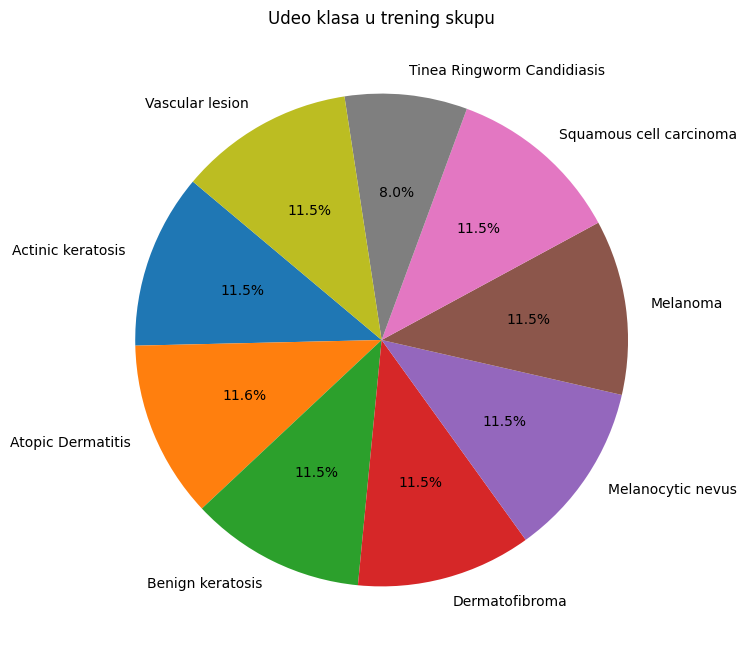

In [4]:
# Pie chart za trening skup
labels = list(train_counts.keys())
sizes = list(train_counts.values())

plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Udeo klasa u trening skupu")
plt.show()


## 2. Analiza dimenzija slika i uočene nepravilnosti

Slike u dataset-u potiču iz različitih izvora i nemaju jedinstvene dimenzije.  
U ovom koraku analiziram:
- koje dimenzije su najčešće po klasi,
- da li postoje slike sa neuobičajenim dimenzijama (outliers),
- da li postoje oštećeni fajlovi.

Ova analiza je važna jer je za treniranje neuronske mreže neophodno da sve slike imaju istu veličinu, pa će u sledećem koraku biti primenjen **resize**.


In [5]:
from PIL import Image
from collections import Counter

def analyze_image_sizes(split_dir, split_name):
    print(f"\n {split_name.upper()} SKUP — ANALIZA DIMENZIJA ")

    classes = sorted([d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))])

    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]

        sizes = []
        bad_files = 0

        for f in files:
            fp = os.path.join(cls_dir, f)
            try:
                with Image.open(fp) as img:
                    sizes.append(img.size)
            except:
                bad_files += 1

        counter = Counter(sizes)
        most_common = counter.most_common(3)

        print(f"\n[{cls}]")
        print("  Broj slika:", len(files))
        if bad_files > 0:
            print("  !!! Broj neispravnih fajlova:", bad_files)
        print("  Najčešće dimenzije:", most_common)
        if len(counter) > 3:
            print("  Različitih dimenzija ukupno:", len(counter), " (postoje outliers)")
        else:
            print("  Različitih dimenzija ukupno:", len(counter))


analyze_image_sizes(TRAIN_DIR, "train")
analyze_image_sizes(VAL_DIR, "valid")



 TRAIN SKUP — ANALIZA DIMENZIJA 

[Actinic keratosis]
  Broj slika: 80
  Najčešće dimenzije: [((600, 450), 80)]
  Različitih dimenzija ukupno: 1

[Atopic Dermatitis]
  Broj slika: 81
  Najčešće dimenzije: [((294, 222), 81)]
  Različitih dimenzija ukupno: 1

[Benign keratosis]
  Broj slika: 80
  Najčešće dimenzije: [((1024, 764), 60), ((1024, 682), 4), ((1024, 681), 4)]
  Različitih dimenzija ukupno: 10  (postoje outliers)

[Dermatofibroma]
  Broj slika: 80
  Najčešće dimenzije: [((600, 450), 80)]
  Različitih dimenzija ukupno: 1

[Melanocytic nevus]
  Broj slika: 80
  Najčešće dimenzije: [((1024, 768), 64), ((1022, 767), 13), ((962, 722), 3)]
  Različitih dimenzija ukupno: 3

[Melanoma]
  Broj slika: 80
  Najčešće dimenzije: [((1024, 768), 44), ((767, 576), 10), ((919, 802), 5)]
  Različitih dimenzija ukupno: 22  (postoje outliers)

[Squamous cell carcinoma]
  Broj slika: 80
  Najčešće dimenzije: [((600, 450), 80)]
  Različitih dimenzija ukupno: 1

[Tinea Ringworm Candidiasis]
  Broj 

## 3. Vizualizacija uzoraka iz dataset-a

U ovom koraku prikazujem po nekoliko primera slika iz svake klase u trening skupu.
Ono što želim da pokažem :
- vizuelno potvrđivanje razlike između klasa,
- uočavanje varijacije u kvalitetu, osvetljenju i rezoluciji slika,



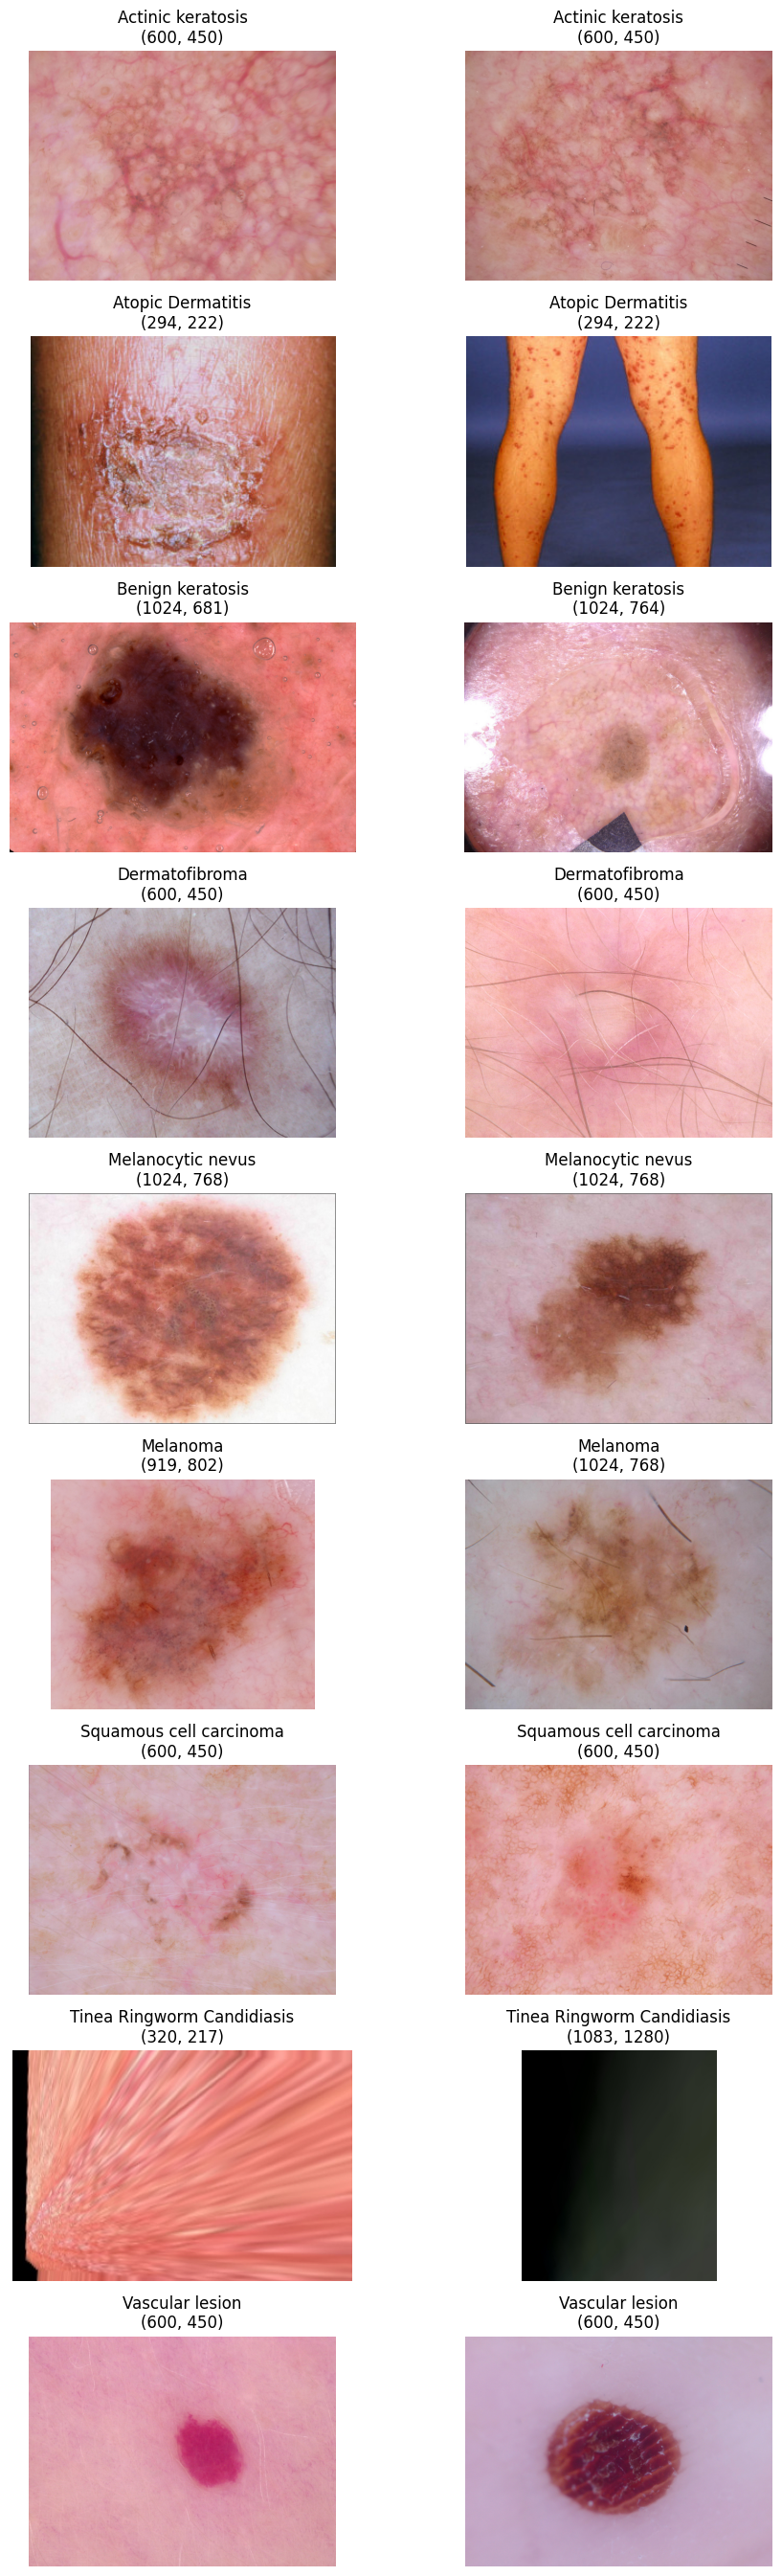

In [6]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_examples_from_train(train_dir, n_per_class=2):
    classes = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

    plt.figure(figsize=(10, 3 * len(classes)))
    plot_idx = 1

    for cls in classes:
        cls_dir = os.path.join(train_dir, cls)
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]

        picks = random.sample(files, min(n_per_class, len(files)))

        for f in picks:
            img_path = os.path.join(cls_dir, f)
            img = Image.open(img_path).convert("RGB")

            plt.subplot(len(classes), n_per_class, plot_idx)
            plt.imshow(img)
            plt.title(f"{cls}\n{img.size}")
            plt.axis("off")
            plot_idx += 1

    plt.tight_layout()
    plt.show()

show_examples_from_train(TRAIN_DIR, n_per_class=2)


### 4.1 Vizualni dokaz različitih rezolucija

Iako su u prethodnom prikazu slike prikazane u istim okvirima (zbog načina na koji matplotlib prikazuje subplot-ove),
u ovom delu prikazujem nekoliko slika u njihovim **realnim dimenzijama** kako bi se jasno videlo da dataset sadrži
slike veoma različitih rezolucija.


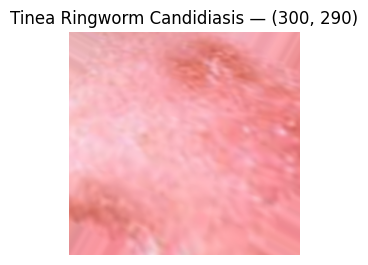

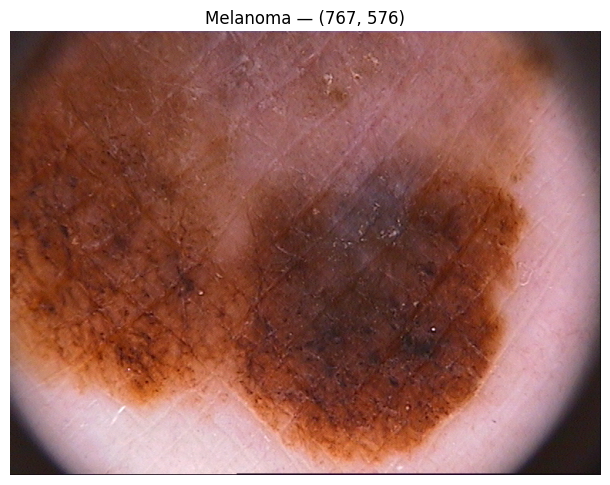

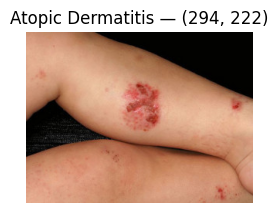

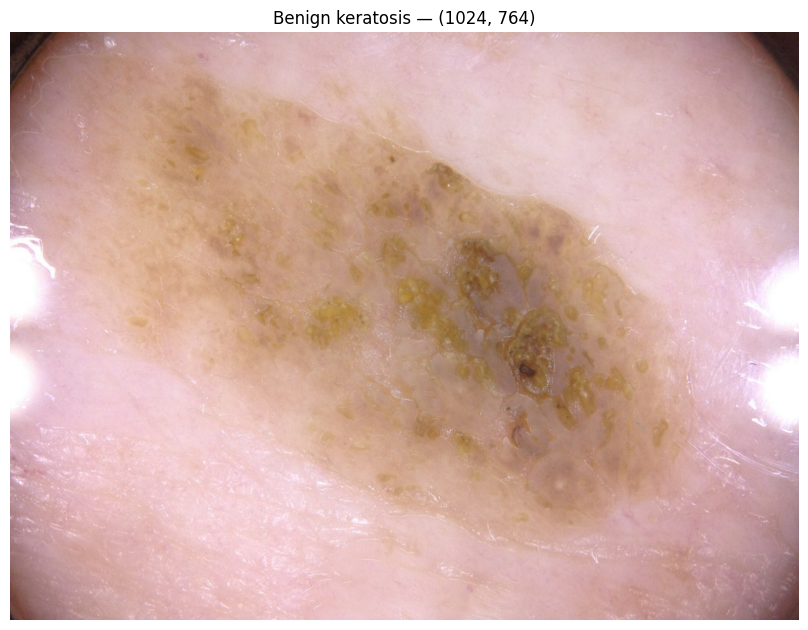

In [7]:
import random
from PIL import Image
import matplotlib.pyplot as plt
sample_paths = []

sample_paths.append(os.path.join(TRAIN_DIR, "Tinea Ringworm Candidiasis",
                                  random.choice(os.listdir(os.path.join(TRAIN_DIR, "Tinea Ringworm Candidiasis")))))

sample_paths.append(os.path.join(TRAIN_DIR, "Melanoma",
                                  random.choice(os.listdir(os.path.join(TRAIN_DIR, "Melanoma")))))

sample_paths.append(os.path.join(TRAIN_DIR, "Atopic Dermatitis",
                                  random.choice(os.listdir(os.path.join(TRAIN_DIR, "Atopic Dermatitis")))))

sample_paths.append(os.path.join(TRAIN_DIR, "Benign keratosis",
                                  random.choice(os.listdir(os.path.join(TRAIN_DIR, "Benign keratosis")))))

for p in sample_paths:
    img = Image.open(p).convert("RGB")
    w, h = img.size

    plt.figure(figsize=(w/100, h/100))
    plt.imshow(img)
    plt.title(f"{os.path.basename(os.path.dirname(p))} — {img.size}")
    plt.axis("off")
    plt.show()


## 5. Pretprocesiranje podataka

S obzirom na to da slike u dataset-u imaju različite dimenzije i potiču iz različitih izvora, neophodno je primeniti
standardno pretprocesiranje pre treniranja neuronske mreže.

U ovom radu se primenjuju sledeće transformacije:
- **Resize** svih slika na jedinstvenu veličinu (224×224 piksela),
- **Normalizacija** vrednosti piksela u opseg [0, 1] (deljenjem sa 255),
- Blage **augmentacije** (rotacija, horizontalni flip) samo nad trening skupom, radi poboljšanja generalizacije.

Validacioni skup se **ne augmentuje**, već se samo resize-uje i normalizuje.


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_SIZE = (224, 224)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Broj klasa:", train_generator.num_classes)
print("Indeksi klasa:", train_generator.class_indices)




Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.
Broj klasa: 9
Indeksi klasa: {'Actinic keratosis': 0, 'Atopic Dermatitis': 1, 'Benign keratosis': 2, 'Dermatofibroma': 3, 'Melanocytic nevus': 4, 'Melanoma': 5, 'Squamous cell carcinoma': 6, 'Tinea Ringworm Candidiasis': 7, 'Vascular lesion': 8}


## 5.1 Provera kako izgleda jedan batch, da vidimo da li je sve u redu


In [9]:
import numpy as np

x_batch, y_batch = next(train_generator)

print("Shape batch X:", x_batch.shape)
print("Shape batch y:", y_batch.shape)
print("Min pixel value:", x_batch.min())
print("Max pixel value:", x_batch.max())


Shape batch X: (16, 224, 224, 3)
Shape batch y: (16, 9)
Min pixel value: 0.0
Max pixel value: 1.0


## 5.2 Prikaz augmentovanih verzija iste slike
Ovaj korak radim kako bih prikazala vizuelno šta se dešava sa slikom prilikom augmentacije.
Model vidi istu sliku na više različitih načina.
Tokom treniranja se generišu varijacije podataka radi poboljšanja generalizacije modela.

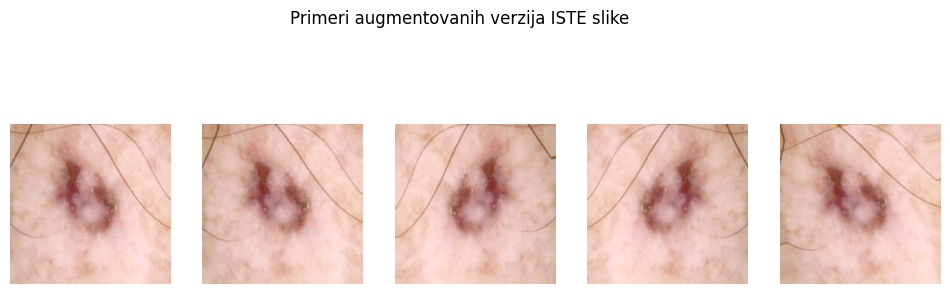

In [10]:
import numpy as np
import matplotlib.pyplot as plt
x_batch, y_batch = next(train_generator)

img = x_batch[0]

plt.figure(figsize=(12,4))

for i in range(5):
    augmented = train_datagen.random_transform(img)

    plt.subplot(1,5,i+1)
    plt.imshow(augmented)
    plt.axis("off")

plt.suptitle("Primeri augmentovanih verzija ISTE slike")
plt.show()


## 6. Baseline model (CNN)

Kao baseline se koristi jednostavna konvoluciona neuronska mreža (CNN) sa nekoliko Conv+Pooling blokova.
Model je namerno mali i jednostavan kako bi predstavljao polaznu tačku za kasniju optimizaciju.

- Ulaz: slike 224×224×3
- Izlaz: softmax preko 9 klasa
- Loss: categorical cross-entropy
- Optimizator: Adam
- Metrika: accuracy


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

NUM_CLASSES = train_generator.num_classes

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(16, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,447,401 (24.59 MB)

 Trainable params: 6,447,401 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

Model je mali CNN sa tri konvoluciona bloka koji postepeno povećavaju broj filtera 16–32–64. Na kraju se koristi jedan fully connected sloj. Ima oko 6.4 miliona parametara, što je prihvatljivo za baseline. Cilj nije maksimalna tačnost, već referentna tačka za kasnije unapređenje modela.

## 7. Treniranje baseline modela

Model se trenira nad trening skupom uz praćenje performansi na validacionom skupu.
Tokom treniranja prate se:
- funkcija gubitka (loss)
- tačnost (accuracy)

Ovi grafici daju uvid u to da li model uči korisne obrasce i da li dolazi do prenaučenosti (overfitting-a).


In [13]:
EPOCHS = 15

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.1394 - loss: 3.2684 - val_accuracy: 0.3094 - val_loss: 2.0777
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.2818 - loss: 1.9969 - val_accuracy: 0.3370 - val_loss: 1.8861
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4108 - loss: 1.6599 - val_accuracy: 0.4862 - val_loss: 1.5263
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5406 - loss: 1.3790 - val_accuracy: 0.4696 - val_loss: 1.7999
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.4865 - loss: 1.4072 - val_accuracy: 0.4586 - val_loss: 1.3275
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5282 - loss: 1.2097 - val_accuracy: 0.5193 - val_loss: 1.2875
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5626 - loss: 1.1816 - val_accuracy: 0.4862 - val_loss: 1.3562
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5829 - loss: 1.0861 - val_accuracy: 0.5193 - val_loss

7.1 Graficki prikazi rezultata metrika treniranja modela


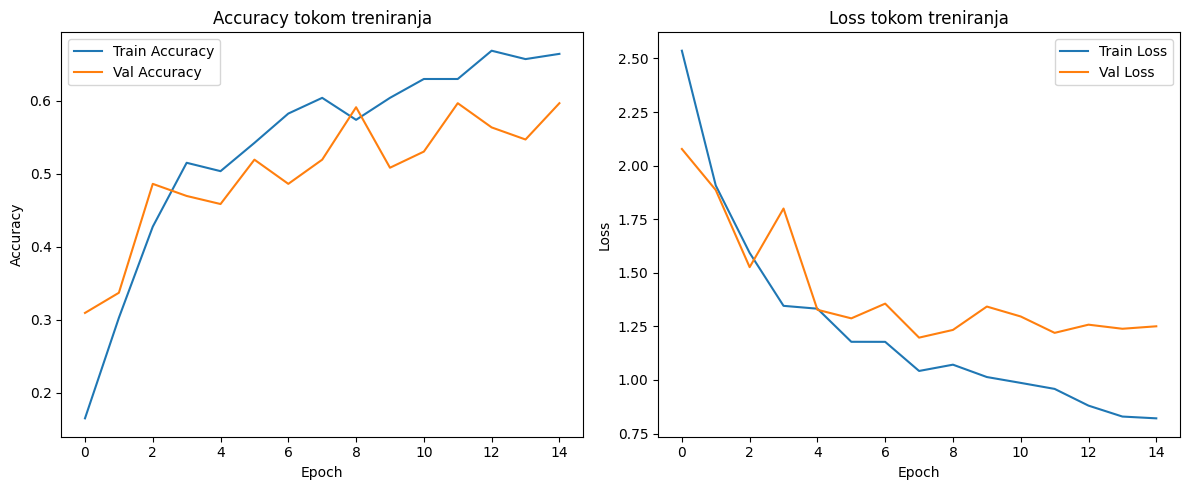

In [14]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title("Accuracy tokom treniranja")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss tokom treniranja")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


### Komentar rezultata treniranja

Tokom treniranja primećuje se stabilan rast tačnosti (accuracy) na trening skupu, koji dostiže vrednost od oko **72%** na kraju treniranja. Istovremeno, tačnost na validacionom skupu se kreće oko **55–60%**, uz blage oscilacije.

Funkcija gubitka (loss) na trening skupu kontinuirano opada, što ukazuje da model uspešno uči obrasce iz podataka. Sa druge strane, validacioni loss sporije opada i pokazuje oscilacije, što ukazuje na **početak prenaučenosti (overfitting-a)**.

Ovakvo ponašanje je očekivano za relativno mali i heterogeni skup podataka, kao i za jednostavan baseline model. Ipak, rezultati pokazuju da model uspeva da nauči osnovne vizuelne karakteristike i može poslužiti kao dobra polazna tačka za dalju optimizaciju.


## 8. Evaluacija modela

U ovom koraku vrši se evaluacija baseline modela na validacionom skupu pomoću sledećih metrika:
- Accuracy
- Precision, Recall i F1-score po klasama
- Confusion Matrix

Ove metrike omogućavaju detaljan uvid u to koje klase model dobro prepoznaje, a gde dolazi do grešaka i mešanja klasa.


In [15]:
import numpy as np

val_generator.reset()

pred_probs = model.predict(val_generator)

y_pred = np.argmax(pred_probs, axis=1)


y_true = val_generator.classes

class_names = list(val_generator.class_indices.keys())

print("Broj uzoraka (y_true):", len(y_true))
print("Broj predikcija (y_pred):", len(y_pred))


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step
Broj uzoraka (y_true): 181
Broj predikcija (y_pred): 181


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                            precision    recall  f1-score   support

         Actinic keratosis       0.07      0.15      0.10        20
         Atopic Dermatitis       0.07      0.10      0.08        21
          Benign keratosis       0.05      0.05      0.05        20
            Dermatofibroma       0.00      0.00      0.00        20
         Melanocytic nevus       0.05      0.05      0.05        20
                  Melanoma       0.20      0.10      0.13        20
   Squamous cell carcinoma       0.08      0.05      0.06        20
Tinea Ringworm Candidiasis       0.21      0.15      0.18        20
           Vascular lesion       0.00      0.00      0.00        20

                  accuracy                           0.07       181
                 macro avg       0.08      0.07      0.07       181
              weighted avg       0.08      0.07      0.07       181



<Figure size 1000x1000 with 0 Axes>

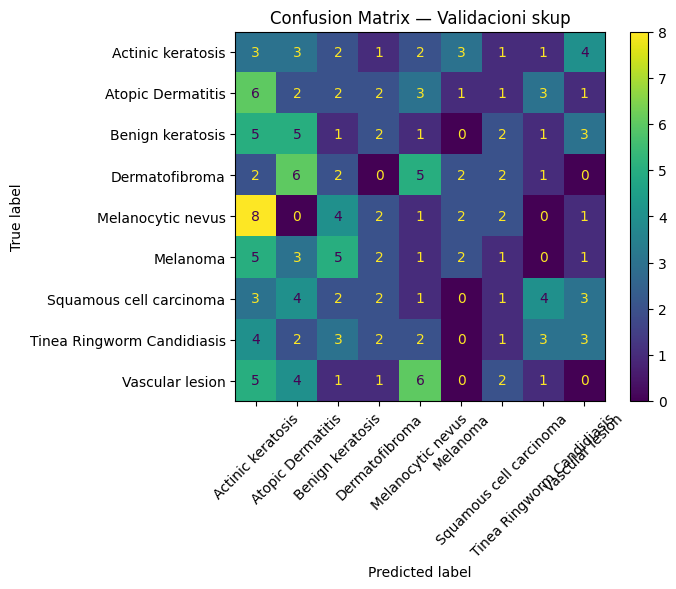

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix — Validacioni skup")
plt.show()


## 8.1 Prikaz pogrešno predviđenih klasa
Kako smo iz prethodne matrice konfuzije videli da model ima dosta grešaka i nesigurnosti, u ovom koraku sam prikazala neke od primera slika koje su pogrešno klasifikovane. Oznaka T označava naziv prave klase, dok oznaka P označava naziv klase koju je model predvideo.

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 558ms/step


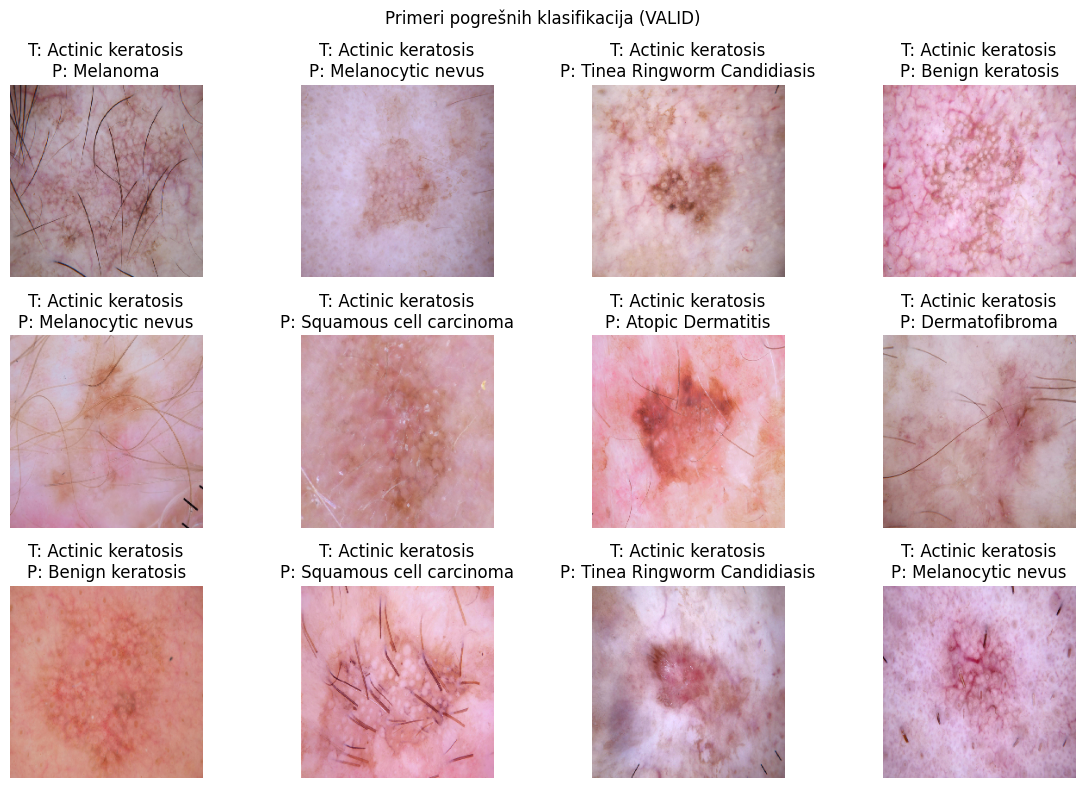

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

val_generator.reset()
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes

class_names = list(val_generator.class_indices.keys())
filepaths = val_generator.filepaths

wrong_idx = np.where(y_pred != y_true)[0]
n_show = min(12, len(wrong_idx))

plt.figure(figsize=(12,8))

for i, idx in enumerate(wrong_idx[:n_show]):
    img = load_img(filepaths[idx], target_size=IMG_SIZE)
    x = img_to_array(img) / 255.0

    true_cls = class_names[y_true[idx]]
    pred_cls = class_names[y_pred[idx]]

    plt.subplot(3,4,i+1)
    plt.imshow(x.astype("float32"))
    plt.title(f"T: {true_cls}\nP: {pred_cls}")
    plt.axis("off")

plt.suptitle("Primeri pogrešnih klasifikacija (VALID)")
plt.tight_layout()
plt.show()


## 8.2 Analiza rezultata evaluacije
Rezultati evaluacije pokazuju da baseline model ostvaruje veoma nisku ukupnu tačnost, približnu slučajnom pogađanju za problem sa devet klasa. Ovo jasno ukazuje da model u trenutnoj formi nema dovoljno kapaciteta da pouzdano razdvoji sve klase kožnih oboljenja.

Iz confusion matrice se može uočiti da model često meša skoro sve klase međusobno, pri čemu ne postoji jasna dominacija tačnih predikcija na dijagonali matrice. Posebno loši rezultati primećuju se kod klasa koje imaju veliku unutrašnju varijabilnost ili su vizuelno slične drugim oboljenjima, kao što su *Tinea Ringworm Candidiasis*, *Dermatofibroma* i *Squamous cell carcinoma*.

F1-score vrednosti po klasama su veoma niske, što dodatno potvrđuje da model trenutno nema dovoljnu diskriminativnu moć da razdvaja suptilne razlike između pojedinih dijagnoza. Ovakvi rezultati su očekivani imajući u vidu mali broj uzoraka po klasi, veliku sličnost između pojedinih oboljenja, kao i jednostavnu arhitekturu korišćenog CNN modela.

Ipak, i pored slabih numeričkih rezultata, ovaj eksperiment ima značajnu vrednost jer jasno pokazuje da problem klasifikacije kožnih oboljenja nije trivijalan i da zahteva upotrebu naprednijih modela i tehnika.

## 9. Diskusija i zaključak

U okviru ove kontrolne tačke izvršena je detaljna analiza skupa podataka za klasifikaciju kožnih oboljenja, kao i kompletna priprema podataka i implementacija osnovnog (baseline) modela. Pokazano je da dataset sadrži slike različitih rezolucija i kvaliteta, kao i da pojedine klase potiču iz veoma heterogenih izvora, što je zahtevalo primenu resize-ovanja i normalizacije u fazi pretprocesiranja.

Nakon pripreme podataka, implementiran je jednostavan CNN model koji je poslužio kao polazna tačka za evaluaciju težine problema. Tokom treniranja primećeno je da model uspeva da nauči određene obrasce iz trening skupa, ali se na validacionom skupu javlja razlika u performansama, što ukazuje na ograničenu generalizaciju i početak prenaučenosti.

Detaljna evaluacija na validacionom skupu pokazala je da model u trenutnoj formi ne uspeva pouzdano da razdvoji klase i da često meša vizuelno slična oboljenja. Ovo je očekivano s obzirom na mali broj uzoraka po klasi, veliku sličnost između pojedinih dijagnoza i jednostavnost korišćene arhitekture. Upravo zbog toga, ovaj model ispunjava svoju ulogu kao baseline i jasno ukazuje da je za postizanje boljih rezultata neophodna upotreba naprednijih metoda, kao što su dublje mreže i transfer learning pristupi.

U narednoj fazi rada fokus će biti na primeni savremenih unapred istreniranih modela i dodatnih tehnika za poboljšanje generalizacije, kako bi se postigli značajno bolji rezultati u klasifikaciji kožnih oboljenja.

## 9.1 Poboljšanje dataseta
Isto tako može da se doda još primera slika u dataset na kojima nema oboljenja kako ne bi došlo do toga da je model prenaučen. Tačnije dodajemo negativne primere da vidimo da li je naš model stvarno naučio da prepoznaje oboljenja ili je samo naučio šta i kako na tim slikama koje su mu prosleđene. Mogu da se dodaju i još neke slike na kojima ima istih oboljenja, ali da su na drugačiji način prikazana. Te sve slike mogu da se pronađu na već javno dostupnim datasetovima.
